#  Non-Linear Modeling



In this lab, we demonstrate some of the nonlinear models discussed in
this chapter. We use the `Wage`  data as a running example, and show that many of the complex non-linear fitting procedures discussed can easily be implemented in Python.

As usual, we start with some of our standard imports.

## Roadmap & learning goals

By the end of this lab, you should be able to:

- **Fit and interpret** non-linear regression curves on the Wage data (mainly `wage` vs. `age`).
- Understand how different models build non-linearity:
  1. **Polynomial regression** (global polynomial basis)
  2. **Regression splines** (piecewise polynomials with knots)
  3. **Natural splines** (splines with linear behavior at the boundaries)
  4. **GAMs / smoothing splines** (additive smooth terms with a smoothness penalty)
  5. **LOWESS** (local regression smoothing)
- **Choose model complexity** using ideas like degrees of freedom / smoothing parameter (`lam`) and (when appropriate) cross-validation.



In [27]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

We again collect the new imports
needed for this lab. Many of these are developed specifically for the
`ISLP` package.

In [28]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

### Polynomial regression

$$
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \cdots + \beta_d x_i^d + \varepsilon_i
$$

Here $x_i$ is `age` and $y_i$ is `wage`. In matrix form, this is just linear regression on a **polynomial feature map**
$\phi(x) = [1, x, x^2, \ldots, x^d]$.

**Layout (conceptual):**

`age`  →  `[1, age, age^2, ..., age^d]`  →  linear regression  →  predicted `wage`

- Increasing degree \(d\) increases flexibility, but high-degree polynomials can behave badly near the boundaries.


Let's  begin by loading the data.

In [29]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [30]:
Wage.head(3)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


Throughout most of this lab, our response is `Wage['wage']`, which
we have stored as `y` above. 
We will use the `poly()` function to create a model matrix
that will fit a $4$th degree polynomial in `age`.

In [31]:
poly_age = MS([poly('age', degree=4,raw=True)]).fit(Wage)
M = sm.GLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,-184.154200,60.040000,-3.067,0.002
"poly(age, degree=4, raw=True)[0]",21.245500,5.887000,3.609,0.000
"poly(age, degree=4, raw=True)[1]",-0.563900,0.206000,-2.736,0.006
"poly(age, degree=4, raw=True)[2]",0.006800,0.003000,2.221,0.026
"poly(age, degree=4, raw=True)[3]",-0.000032,0.000016,-1.952,0.051


In the code above, the first line executes the `fit()` method
using the dataframe
`Wage`. This recomputes and stores as attributes any parameters needed by `Poly()`
on the training data, and these will be used on all subsequent
evaluations of the `transform()` method. For example, it is used
on the second line, as well as in the plotting function developed below.

We now create a grid of values for `age` at which we want
predictions.

In [32]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
age_df = pd.DataFrame({'age': age_grid})

### Plotting the data with a 4th-degree polynomial fit

Next, we’ll plot the data and overlay the fitted 4th-degree polynomial curve. Since we’ll create several similar plots later, we’ll first write a helper function to generate them consistently.

**The function will:**
- take a model specification (a chosen `basis`/transform) and a grid of `age` values,
- compute fitted values on the grid,
- add **95% confidence bands**, and
- produce the plot.

Because `basis` is an input, we can reuse the same function for other transforms as well (e.g., splines, introduced next).


In [33]:
def plot_wage_fit(age_df, 
                  basis,
                  title):

    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

In `ax.scatter()`, we set `alpha` to make the points semi-transparent. This helps reveal where the data are dense (darker areas mean more overlap).

The loop plots **three** lines:
- the fitted curve (`preds.predicted_mean`)
- the lower 95% confidence bound (`bands[:, 0]`)
- the upper 95% confidence bound (`bands[:, 1]`)

We use `zip()` to pair each line with a style (`'b'`, `'r--'`, `'r--'`) so we can plot them in a short, clean loop.

Next, we use this function to plot the 4th-degree polynomial fit.


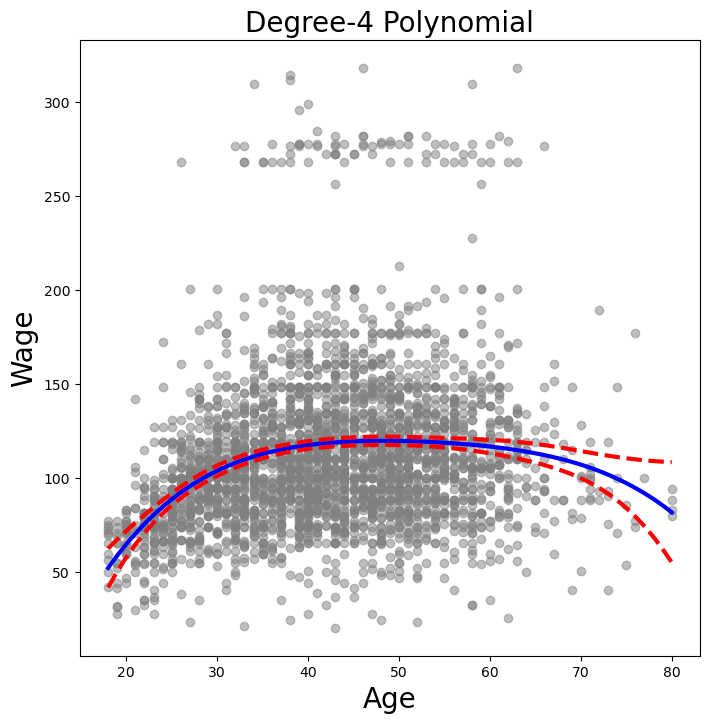

In [34]:
plot_wage_fit(age_df, 
              poly_age,
              'Degree-4 Polynomial');

## Splines
In order to fit regression splines, we use transforms
from the `ISLP` package. The actual spline
evaluation functions are in the `scipy.interpolate` package;
we have simply wrapped them as transforms
similar to `Poly()` and `PCA()`.

In lecture, we saw
that regression splines can be fit by constructing an appropriate
matrix of basis functions.  The `BSpline()`  function generates the
entire matrix of basis functions for splines with the specified set of
knots. By default, the B-splines produced are cubic. To change the degree, use
the argument `degree`.

### Regression splines

A **regression spline** models \(f(x)\) as a piecewise polynomial. A common (cubic) form is:

$$
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 \;+\; \sum_{k=1}^{K} \gamma_k (x_i-\kappa_k)_+^3 \;+\; \varepsilon_i
$$

where $(u)_+ = \max(u, 0)$ and $\kappa_1,\ldots,\kappa_K$ are **knots**.

**Layout (conceptual):**

`age`  →  spline basis functions (depend on knots)  →  linear regression  →  predicted `wage`

- Knots control where the curve is allowed to bend. More knots (or higher df) → more flexibility.

In [35]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

This produces a **7-column** design matrix, as expected for a **cubic spline** with **3 interior knots**.

We can get the same matrix using `bs()`, which is easier to plug into a model formula (similar to how `poly()` is a convenient wrapper around `Poly()`).

Next, we fit a cubic spline model to the `Wage` data.


In [36]:
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


Notice that there are 6 spline coefficients rather than 7. This is because, by default,
`bs()` assumes `intercept=False`, since we typically have an overall intercept in the model.
So it generates the spline basis with the given knots,  and then discards one of the basis functions to account for the intercept. 

We could also use the `df` (degrees of freedom) option to
specify the complexity of the spline.  We see above that with 3 knots,
the spline basis has 6 columns or degrees of freedom.  When we specify
`df=6` rather than the actual knots, `bs()` will produce a
spline with 3 knots chosen at uniform quantiles of the training data.
We can see these chosen knots most easily using `Bspline()` directly:

In [37]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

 When asking for six degrees of freedom,
the transform chooses knots at ages 33.75, 42.0, and 51.0,
which correspond to the 25th, 50th, and 75th percentiles of
`age`.

When using B-splines we need not limit ourselves to cubic polynomials
(i.e. `degree=3`). For instance, using `degree=0` results
in piecewise constant functions.

In [38]:
bs_age0 = MS([bs('age',
                 df=3, 
                 degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


## Natural Spline
In order to fit a natural spline, we use the `NaturalSpline()` 
transform with the corresponding helper `ns()`.  Here we fit a natural spline with five
degrees of freedom (excluding the intercept) and plot the results.


A **natural spline** is a cubic spline with extra boundary constraints so it behaves more stably near the edges.

One way to state it:

- $f(x)$ is a **cubic spline** with knots $\kappa_1,\ldots,\kappa_K$
- and it is **linear beyond the boundary knots** (equivalently, \(f''(x)=0\) outside the boundary interval).

So we still model:

$$
y_i = \beta_0 + f(x_i) + \varepsilon_i
$$

but $f$ is restricted to avoid extreme curvature at the ends.


- Natural splines often extrapolate more reasonably than ordinary cubic splines.

In [39]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


We now plot the natural spline using our plotting function.

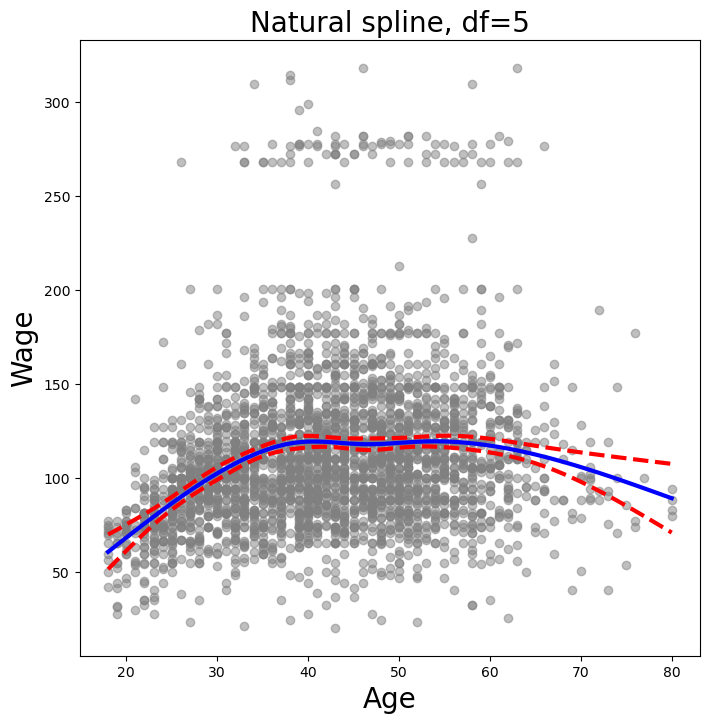

In [40]:
plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=5');

## GAMs

$$
y \approx \beta_0 + f_1(x_1) + f_2(x_2) + \cdots + \varepsilon
$$


We’ll fit GAMs in Python with **pygam**:

- `LinearGAM()` uses squared-error loss.
- You specify what to do with each feature (each column of `X`) using terms:
  - `s(i)`: smooth spline on column `i`
  - `l(i)`: linear term on column `i`
  - `f(i)`: categorical (factor) term on column `i`

Here we use `s(0)` because `X_age` has **one column**, so age is column **0**.

`lam` is the **smoothness penalty**:
- larger `lam` → **smoother** curve (more regularization)
- smaller `lam` → **wigglier** curve
**Penalized fitting idea (what `lam` controls):**

$$
\hat f \;=\; \arg\min_{f} \;\sum_{i=1}^n (y_i - f(x_i))^2 \;+\; \lambda \int \big(f''(t)\big)^2\,dt
$$

- $\lambda$ large → stronger penalty on curvature → smoother $f$
- $\lambda$ small → weaker penalty → more flexible → wigglier $f$

**Layout (conceptual):**

`(x1, x2, ...)`  →  `[f1(x1) + f2(x2) + ...]`  →  sum with intercept  →  predicted `y`


In [41]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

### Why reshape `age`?

`pygam` expects **X to be a 2D feature matrix** (shape: `n_samples × n_features`).  
So we reshape `age` from a 1D vector `(n,)` to a 2D matrix `(n, 1)`:

- `reshape(-1, 1)` means: make it one column, and let NumPy infer how many rows (`-1`).

### Exploring the smoothing parameter `lam`

We’ll see how the fit changes as `lam` changes.  
`np.logspace()` creates values **evenly spaced on a log scale**, which is useful for trying penalties across many orders of magnitude.

Here we try `lam` from **1e-2** to **1e6**.


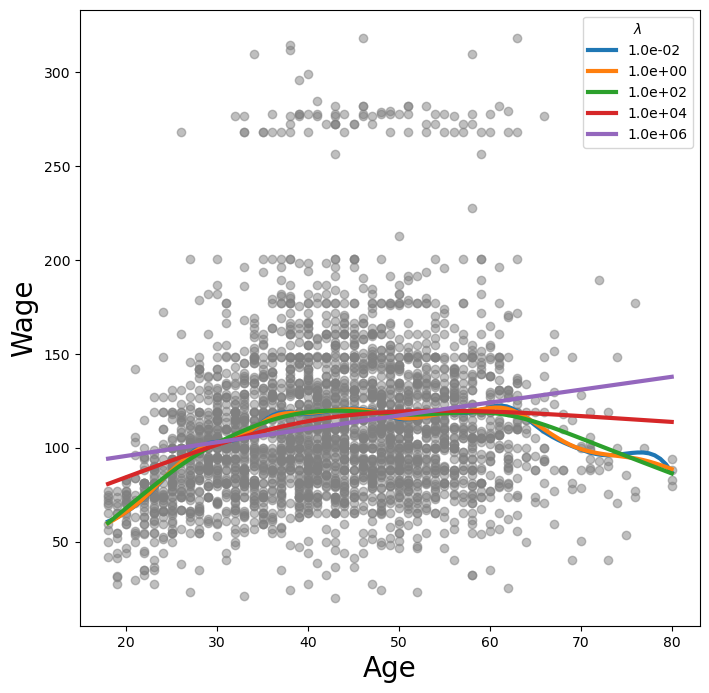

In [42]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');

The `pygam` package can perform a search for an optimal smoothing parameter.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


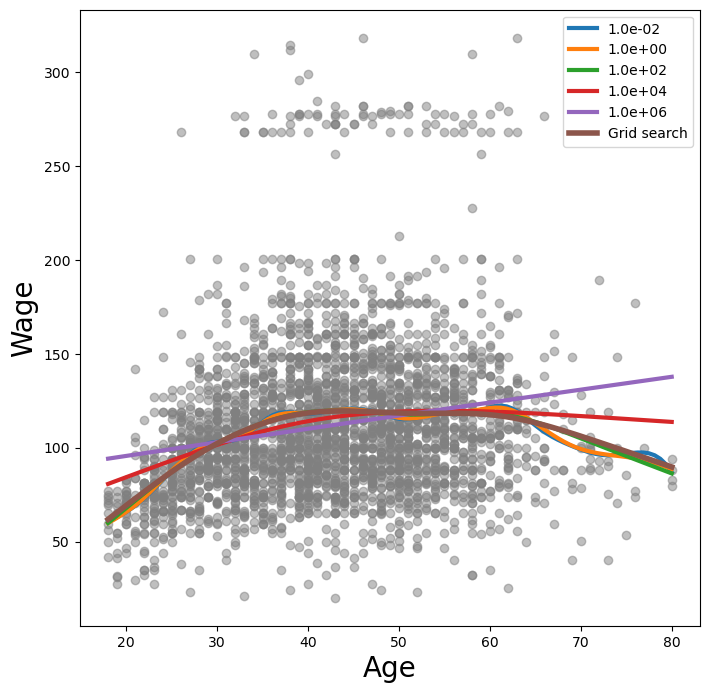

In [43]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

## Additive Models with Several Terms

Generalized Additive Models (GAMs) extend linear regression by letting each predictor have its **own flexible shape**, then **adding** the effects together. This gives more flexibility than a purely linear model.

We’ll show two ways to fit a multivariate GAM:

1. **By hand (manual basis expansion):**  
   - Use **natural splines** for `year` and `age`  
   - Treat `education` as a **categorical** predictor (piecewise-constant effects)  
   - Fit the resulting “big linear model” with `statsmodels.OLS`

2. **With `pygam`:**  
   - Use smoothing splines directly via the GAM API

In this section, we do it **by hand** so we can keep each component (e.g., the `age` spline part) separate—this makes it easy to build **partial dependence plots** later.



A **multivariate additive model** for Wage:

$$
\text{wage}_i
= \beta_0
+ f_{\text{year}}(\text{year}_i)
+ f_{\text{age}}(\text{age}_i)
+ \sum_{j} \beta_j \, \mathbb{1}\{\text{education}_i = j\}
+ \varepsilon_i
$$

This is still a **linear model in a feature/basis expansion**, but some blocks of features come from spline bases.

- Additivity makes the model interpretable (separate partial effects), but it cannot represent strong interactions unless you add interaction terms explicitly.


In [44]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

### Building the model matrix

`NaturalSpline()` (used by the helper `ns()`) creates the spline basis for `age` and `year`.  
For `education`, we include **all dummy columns**, so we **don’t need an intercept** (it would be redundant).

We then **horizontally stack** the three parts (year spline, age spline, education dummies) to form the full design matrix `X_bh`.

### Partial dependence plots (by hand)

To plot each term’s effect, we create grids for `age` and `year` and make predictions with new design matrices while:
- varying **one** feature over its grid, and  
- holding the other features **fixed** (e.g., at typical values).

This isolates the contribution of each term for visualization.


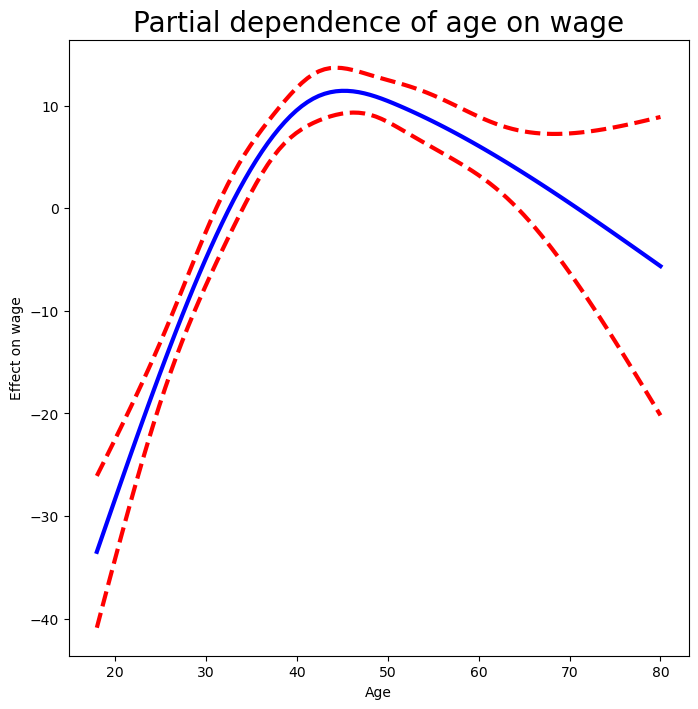

In [45]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

Let's explain in some detail what we did above. The idea is to create a new prediction matrix, where all but the columns belonging to `age` are constant (and set to  their training-data means). The four columns for `age` are filled in with the natural spline basis evaluated at the 100 values in `age_grid`.

* We made a grid of length 100 in `age`, and created a matrix `X_age_bh` with 100 rows and the same number of columns as `X_bh`.
* We replaced every row of this matrix with the column means of the original.
* We then replace just the first four columns representing `age` with the natural spline basis computed at the values in `age_grid`. 

The remaining steps should by now be familiar.

We also look at the effect of `year` on `wage`; the process is the same.

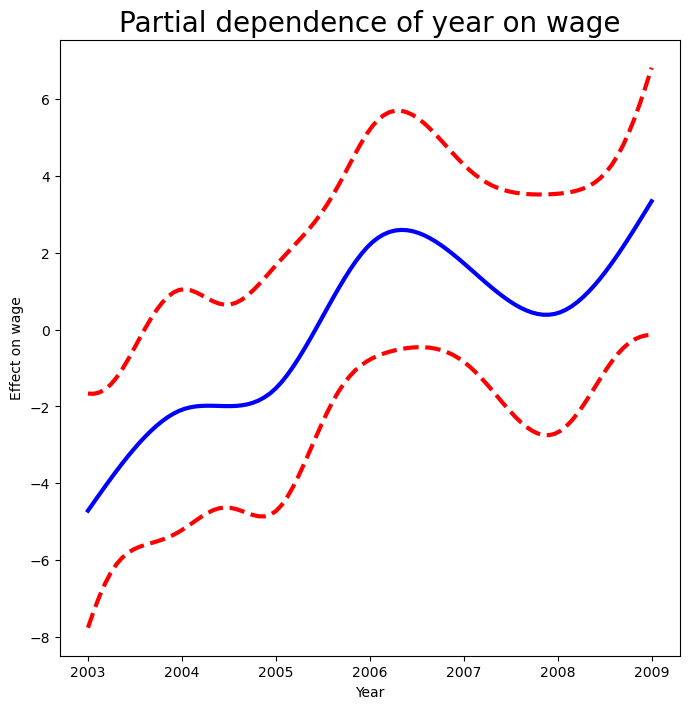

In [46]:
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

### Fitting with smoothing splines (pygam)

Now we use **smoothing splines** instead of natural splines.  

`pygam` expects a **feature matrix**, so we convert the categorical variable `education`
to integer codes using `education.cat.codes`.

Since `year` has only **7 unique values**, we limit its spline to **7 basis functions**.


In [47]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

The two `s_gam()` terms result in smoothing spline fits, and use a default value for $\lambda$  (`lam=0.6`), which is somewhat arbitrary. For the categorical term `education`, specified using a `f_gam()` term,  we specify `lam=0` to avoid any shrinkage.
We produce the partial dependence plot in `age` to see the effect of these choices.

The values for the plot
are generated by the `pygam` package. We provide a `plot_gam()`
function for partial-dependence plots in `ISLP.pygam`, which makes this job easier than in our last example with natural splines.

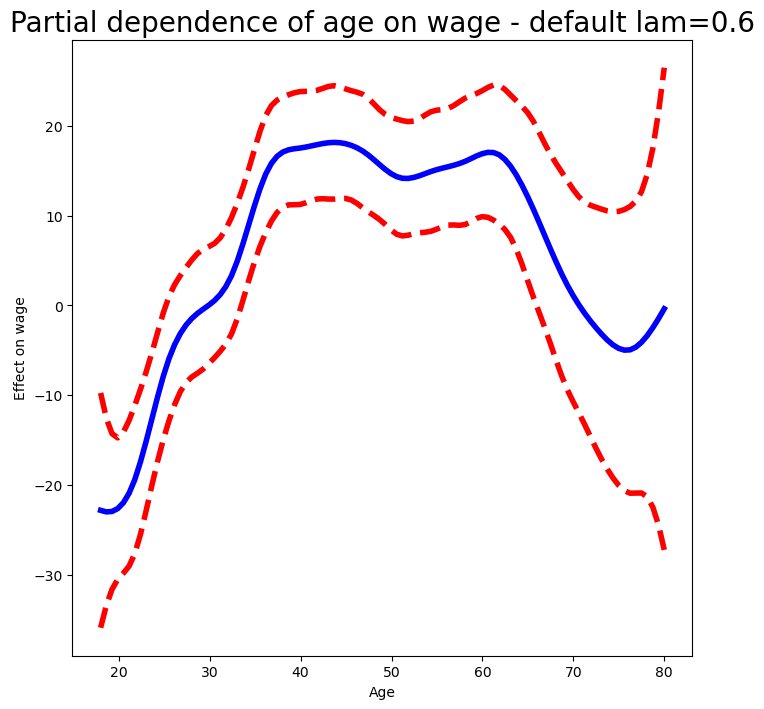

In [48]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20);

We see that the function is somewhat wiggly. It is more natural to specify the `df` than a value for `lam`. 
We refit a GAM using four degrees of freedom each for
`age` and  `year`. Recall that the addition of one below takes into account the intercept
of the smoothing spline.

In [49]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Note that updating `age_term.lam` above updates it in `gam_full.terms[0]` as well! Likewise for `year_term.lam`.

Repeating the plot for `age`, we see that it is much smoother.
We also produce the plot for `year`.

Text(0.5, 1.0, 'Partial dependence of year on wage')

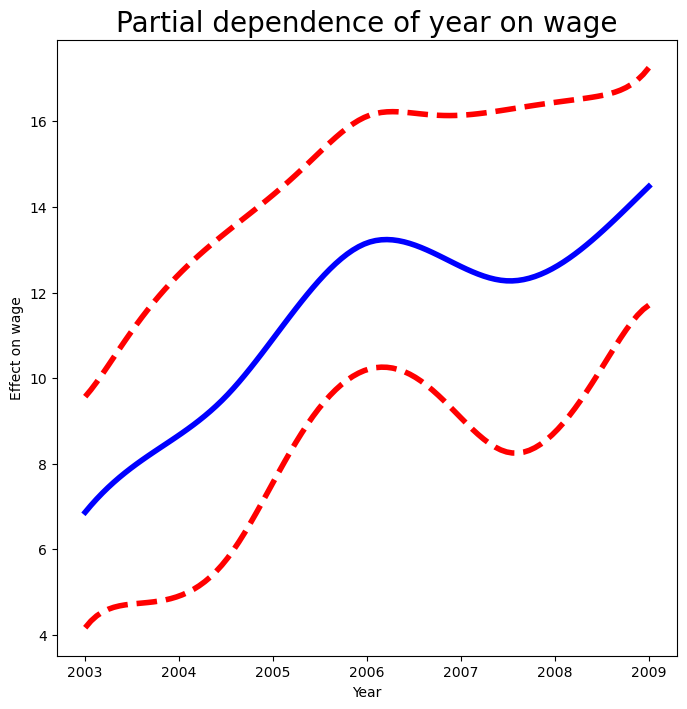

In [50]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
         1,
         ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

Finally we plot `education`, which is categorical. The partial dependence plot is different, and more suitable for the set of fitted constants for each level of this variable.

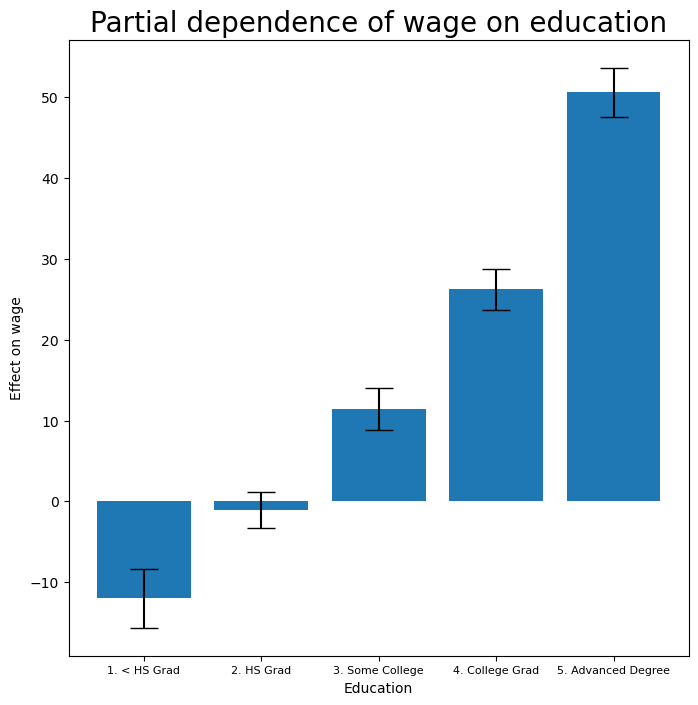

In [51]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

### LOWESS (local regression)

LOWESS fits a **local** model around each target point \(x_0\). For local linear LOWESS:

$$
(\hat a(x_0), \hat b(x_0))
= \arg\min_{a,b}\;\sum_{i=1}^n w_i(x_0)\,\big(y_i - a - b x_i\big)^2
$$

and the fitted curve is $$\hat f(x_0) = \hat a(x_0) + \hat b(x_0)\,x_0$$.

The weights $w_i(x_0)$ decrease as $x_i$ moves away from $x_0$; `frac` controls how wide the neighborhood is.

**Layout (conceptual):**

Pick $x_0$ → select nearby points (controlled by `frac`) → fit local line → output $\hat f(x_0)$



We’ll use **LOWESS** (locally weighted regression) via `statsmodels`:
`sm.nonparametric.lowess()`.

Below we fit **local linear** models with two spans:
- `frac=0.2`: each fit uses the nearest **20%** of points → **less smooth**
- `frac=0.5`: each fit uses the nearest **50%** of points → **more smooth**


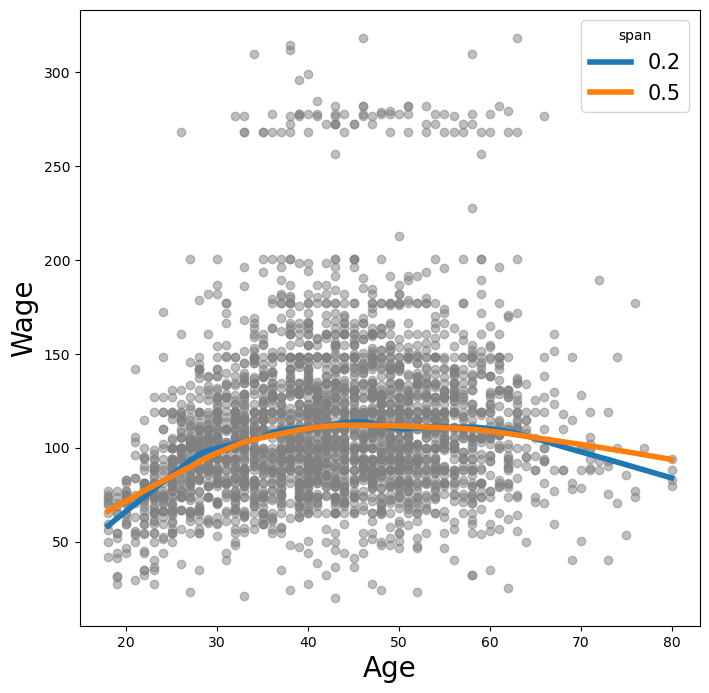

In [52]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
                    age,
                    frac=span,
                    xvals=age_grid)
    ax.plot(age_grid,
            fitted,
            label='{:.1f}'.format(span),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);

## Summary and a question to think about

### What we learned (big picture)
- **Polynomial regression:** global basis $1, x, x^2, \ldots$. Simple, but high degree can overfit and behave oddly near boundaries.
- **Regression splines:** piecewise polynomials with **knots** → local flexibility.
- **Natural splines:** like cubic splines, but **linear tails** → usually more stable at the boundaries.
- **GAMs / smoothing splines:** model $y$ as a sum of smooth functions; **`lam` controls smoothness** via a penalty on curvature.
- **LOWESS:** a nonparametric smoother that fits **local** regressions around each $x_0$.

### Open-ended question: how do we choose among these models?
There’s no single best answer—here are a few practical hints:

1. **What’s the goal?**  
   - Interpretation (clear partial effects) → splines / GAMs  
   - Pure prediction → choose complexity by cross-validation (degree/df/`lam`)
2. **Do you care about boundary behavior / extrapolation?**  
   - Natural splines or stronger regularization often behave better near the edges.
3. **How many predictors do you have?**  
   - Many predictors → GAMs are a natural next step (additive structure)  
   - LOWESS is mostly used for 1D smoothing.
4. **How much data do you have?**  
   - More data supports more flexibility; with small data, regularization matters more.

If you have time, try: *fit two models with different complexity (e.g., different df or different `lam`) and compare them using a validation split.*  
What changes: the training error, the test error, and the “wiggliness” of the curve?
